# Trabajo asistido :  Ruta más corta

BlueDrop Logistics es una empresa especializada en entregas urgentes de insumos médicos en áreas críticas. Cada día debe visitar 10 puntos estratégicos, denominados de D1 a D10. La entrega en cada punto debe realizarse dentro de una ventana de tiempo específica, y no se permite esperar si el camión llega antes del inicio de la ventana.

La red vial incluye distintos tipos de terreno (urbano, suburbano o periurbano ), que afectan directamente el costo de desplazamiento.
### Datos generales:

- **Velocidad del camión:** 50 km/h (0.83 km/min).

- **Tipos de terreno y costo por km:**
  - Urbano: 	600 COP/km
  - Suburbano : 900 COP/km
  - Periurbano: 1100 COP/km

- **Función de costo:**
$
\text{Costo Total} = \sum_{(i, j) \in \text{Ruta}} \text{Distancia}_{ij} \times \text{CostoPorKm}_{ij}
$

  Donde:

  - $\text{Distancia}_{ij} $ es la distancia en kilómetros entre los nodos \( i \) y \( j \),
  - $\text{CostoPorKm}_{ij} $ depende del tipo de terreno

- **Condiciones para marcar un nodo como visitado:**
  1. El nodo tiene el menor costo acumulado.
  2. La llegada al nodo ocurre dentro de la ventana de tiempo especificada.
  3. No se permite esperar si el camión llega antes de la hora de apertura de un nodo.

- **Hora de salida:** El camión parte del nodo **D1** a las **6:00 h**.

La información de distancias, tipo de terreno y ventanas de tiempo está disponible en el archivo **BlueDrop_Datos.xlsx**, distribuida de la siguiente forma:

1. **Matriz de Rutas:** contiene las columnas `Origen`, `Destino`, `Distancia (km)`, `Tipo de Terreno`.
2. **Ventanas de Tiempo:** contiene las columnas `Nodo`, `Ventana inicio (h)`, `Ventana fin (h)`. Tenga en cuenta que el nodo D1 es 24 horas.

---

## Preguntas

### Pregunta 1 (2 puntos)

Escriba el pseudocódigo del algoritmo de  Dijkstra que permita encontrar la ruta con menor costo total, respetando las condiciones del enunciado.

Escriba su pseudocódigo aquí

### Pregunta 1 – Pseudocódigo del algoritmo de Dijkstra con restricciones

1. Inicializar:
   - `costo[nodo] ← ∞` para todos los nodos excepto `D1` que se inicializa en 0.
   - `tiempo[nodo] ← ∞` para todos los nodos excepto `D1` que se inicializa en 6.0 h.
   - `previo[nodo] ← None` para todos los nodos.
   - `no_visitados ← {todos los nodos}`

2. Mientras `no_visitados` no esté vacío:
   - Seleccionar `actual ← nodo con menor costo acumulado` entre los no visitados.
   - Si `tiempo[actual] > fin de ventana[actual]`: descartar nodo.
   - Marcar `actual` como definitivo (agregarlo al orden de marcado).
   - Remover `actual` de `no_visitados`.

3. Para cada vecino de `actual`:
   - Calcular `tiempo_llegada ← tiempo[actual] + distancia / velocidad`
   - Si `inicio_ventana ≤ tiempo_llegada ≤ fin_ventana`:
     - Calcular `nuevo_costo ← costo[actual] + (distancia × costo_por_km según terreno)`
     - Si `nuevo_costo < costo[vecino]`:
       - Actualizar `costo[vecino]`, `tiempo[vecino]`, `previo[vecino]`

4. Al finalizar, usar `previo` para reconstruir la ruta más barata desde `D1` hasta `D10`.


---

### Pregunta 2 (1 punto)

Inserte el grafo dirigido que representa las conexiones entre los nodos del sistema logístico. Cada arco debe mostrar el costo asociado al tramo (en COP), calculado según distancia y tipo de terreno.

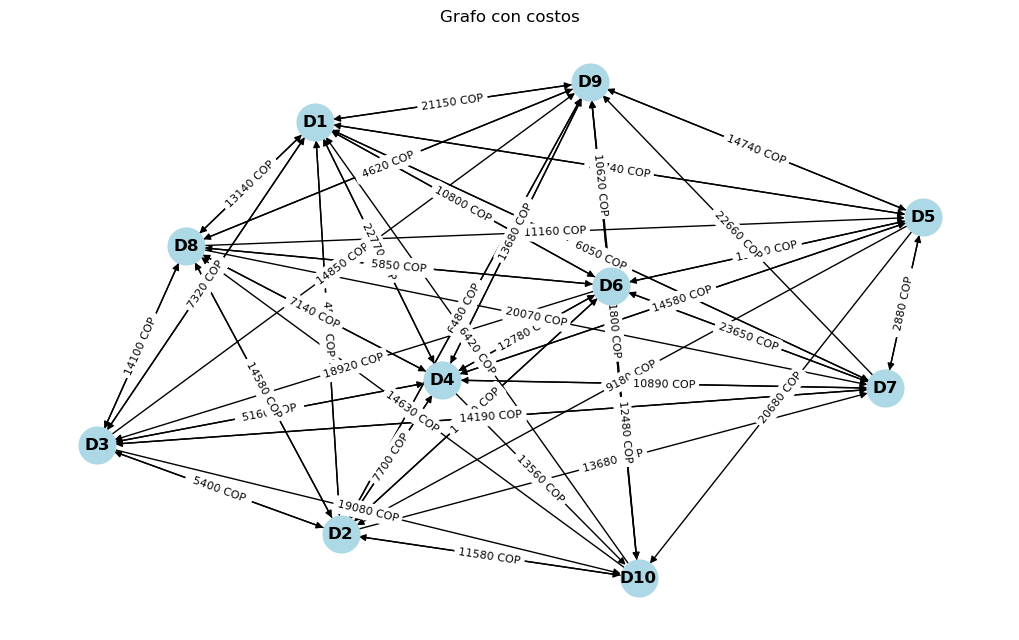

In [ ]:
#Código pregunta 2

# Cargar librerías
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Cargar archivo Excel
archivo = 'BlueDrop_Datos.xlsx'
df_arcos = pd.read_excel(archivo, sheet_name='Matriz de Rutas')
df_ventanas = pd.read_excel(archivo, sheet_name='Ventanas de Tiempo')

#  Construir grafo dirigido con costos por terreno
G = nx.DiGraph()
for _, row in df_arcos.iterrows():
    tipo = row['Tipo de terreno']
    costo_km = {'Urbano': 600, 'Suburbano': 900, 'Periurbano': 1100}[tipo]
    G.add_edge(row['Origen'], row['Destino'],
               distancia=row['Distancia (km)'],
               terreno=tipo,
               costo=row['Distancia (km)'] * costo_km)

# ⚙️ Parámetros
velocidad = 50  # km/h
hora_inicio = 6.0  # 6:00 a.m.
ventanas = {
    row['Nodo']: (float(row['Ventana inicio (h)']), float(row['Ventana fin (h)']))
    for _, row in df_ventanas.iterrows()
}

ventanas['D1'] = (6, 24)  # ventana amplia para nodo inicial


# Pregunta 2 – Mostrar grafo con etiquetas de costo y tipo de terreno
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G, seed=42)

# Dibujar nodos y aristas
nx.draw(G, pos, with_labels=True, node_size=700, node_color='lightblue', font_weight='bold')

# Etiquetas de aristas
edge_labels = {
    (u, v): f"{int(d['costo'])} COP"
    for u, v, d in G.edges(data=True)
}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

plt.title("Grafo con costos")
plt.axis('off')
plt.show()


---

### Pregunta 3 (2 puntos)

Determine la ruta óptima desde **D1 hasta D10**, e indique claramente:

| Elemento                     | Resultado                 |
|------------------------------|--------------------------|
| Ruta (nodos)                 |                          |
| Distancia total (km)        |                          |
| Tiempo total (h)            |                          |
| Costo total (COP)     |                          |

In [ ]:
#Código pregunta 3
def analizar_ruta_dijkstra(G, inicio, final, ventanas, velocidad=50, hora_inicio=6.0):
    """
    Ejecuta Dijkstra adaptado desde `inicio` hasta `final`, respetando ventanas de tiempo
    y sin esperar. Muestra la ruta óptima y sus métricas.
    """
    # Inicialización
    costo = {n: float('inf') for n in G.nodes}
    tiempo = {n: float('inf') for n in G.nodes}
    previo = {n: None for n in G.nodes}
    marcado = []

    costo[inicio] = 0
    tiempo[inicio] = hora_inicio
    no_visitados = set(G.nodes)

    while no_visitados:
        actual = min(no_visitados, key=lambda n: costo[n])
        if tiempo[actual] > ventanas[actual][1]:
            no_visitados.remove(actual)
            continue

        marcado.append(actual)
        no_visitados.remove(actual)

        for vecino in G.successors(actual):
            if vecino in no_visitados:
                dist = G[actual][vecino]['distancia']
                costo_tramo = G[actual][vecino]['costo']
                tiempo_tramo = dist / velocidad
                llegada = tiempo[actual] + tiempo_tramo

                if ventanas[vecino][0] <= llegada <= ventanas[vecino][1]:
                    if costo[actual] + costo_tramo < costo[vecino]:
                        costo[vecino] = costo[actual] + costo_tramo
                        tiempo[vecino] = llegada
                        previo[vecino] = actual

    # Reconstruir ruta
    ruta = []
    actual = final
    while actual is not None:
        ruta.append(actual)
        actual = previo[actual]
    ruta.reverse()

    # Calcular métricas
    distancia_total = 0
    costo_total = 0
    for i in range(len(ruta) - 1):
        u, v = ruta[i], ruta[i+1]
        distancia_total += G[u][v]['distancia']
        costo_total += G[u][v]['costo']

    return ruta, distancia_total, tiempo[final], costo_total

ruta, distancia, tiempo, costo = analizar_ruta_dijkstra(G, 'D1', 'D10', ventanas)

# Mostrar resultados 
print("----- RESULTADOS RESUMIDOS -----")
print("Ruta (nodos):             ", " → ".join(ruta))
print(f"Distancia total (km):     {distancia:.2f}")
print(f"Tiempo total (h):         {tiempo:.2f}")
print(f"Costo total (COP):        {costo:,.0f}")
print("--------------------------------")



----- RESULTADOS RESUMIDOS -----
Ruta (nodos):              D1 → D2 → D10
Distancia total (km):     30.20
Tiempo total (h):         6.60
Costo total (COP):        27,180
--------------------------------


---

### BONO: Pregunta 4 (1 punto)

Indique el orden de marcado de los nodos desde D1 al ejecutar el algoritmo, es decir, el orden en el que se va visitando cada nodo (Este orden representa el flujo de decisiones del algoritmo, no necesariamente la ruta óptima):

```
Orden de Marcado:
```

In [ ]:
#Código pregunta  4

def dijkstra_costos(G, inicio):
    costo = {n: float('inf') for n in G.nodes}
    tiempo = {n: float('inf') for n in G.nodes}
    previo = {n: None for n in G.nodes}
    marcado = []

    costo[inicio] = 0
    tiempo[inicio] = hora_inicio
    no_visitados = set(G.nodes)

    while no_visitados:
        actual = min(no_visitados, key=lambda n: costo[n])
        if tiempo[actual] > ventanas[actual][1]:
            no_visitados.remove(actual)
            continue

        marcado.append(actual)
        no_visitados.remove(actual)

        for vecino in G.successors(actual):
            if vecino in no_visitados:
                dist = G[actual][vecino]['distancia']
                costo_tramo = G[actual][vecino]['costo']
                tiempo_tramo = dist / velocidad
                llegada = tiempo[actual] + tiempo_tramo

                if ventanas[vecino][0] <= llegada <= ventanas[vecino][1]:
                    if costo[actual] + costo_tramo < costo[vecino]:
                        costo[vecino] = costo[actual] + costo_tramo
                        tiempo[vecino] = llegada
                        previo[vecino] = actual

    return costo, tiempo, previo, marcado

# Ejecutar desde D1
costo_total, tiempo_total, previo, marcado = dijkstra_costos(G, 'D1')


def mostrar_orden_marcado(marcado):
    print("Orden de marcado de los nodos:")
    for i, nodo in enumerate(marcado, 1):
        print(f"{i}. {nodo}")

mostrar_orden_marcado(marcado)